## Esercizi
1. Attivare il Runtime della GPU e verificare che funzioni.
2. Caricare il dataset MNIST (cercare sulla documentazione come fare) e capirne le caratteristiche, eseguendo anche l'esplorazione del dataset.
3. Creare una CNN compatibile con il dataset, eseguire i calcoli di parametri e output shape.
4. Allenare la CNN.
5. Testare la CNN e calcolare l'accuracy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import os
import random

### Seed per riproducibilità

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(0)


1. Attivare il Runtime della GPU e verificare che funzioni


In [3]:
torch.cuda.is_available()

False

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

2. Caricare il dataset MNIST (cercare sulla documentazione come fare) e capirne le caratteristiche, eseguendo anche l'esplorazione del dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [6]:
#download train e test set

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51756467.11it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1654249.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14231429.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1045239.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
# funzione per convertire un'immagine da tensore ad un formato visualizzabile

def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return npimg.squeeze()


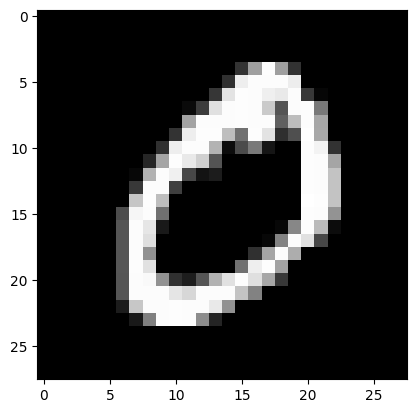

In [9]:
image = back_to_image(trainset[1][0])
plt.imshow(image, cmap='gray')
plt.show()

In [10]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [11]:
classes[int(trainset[1][1])]

'0'

In [12]:
iteration = 0

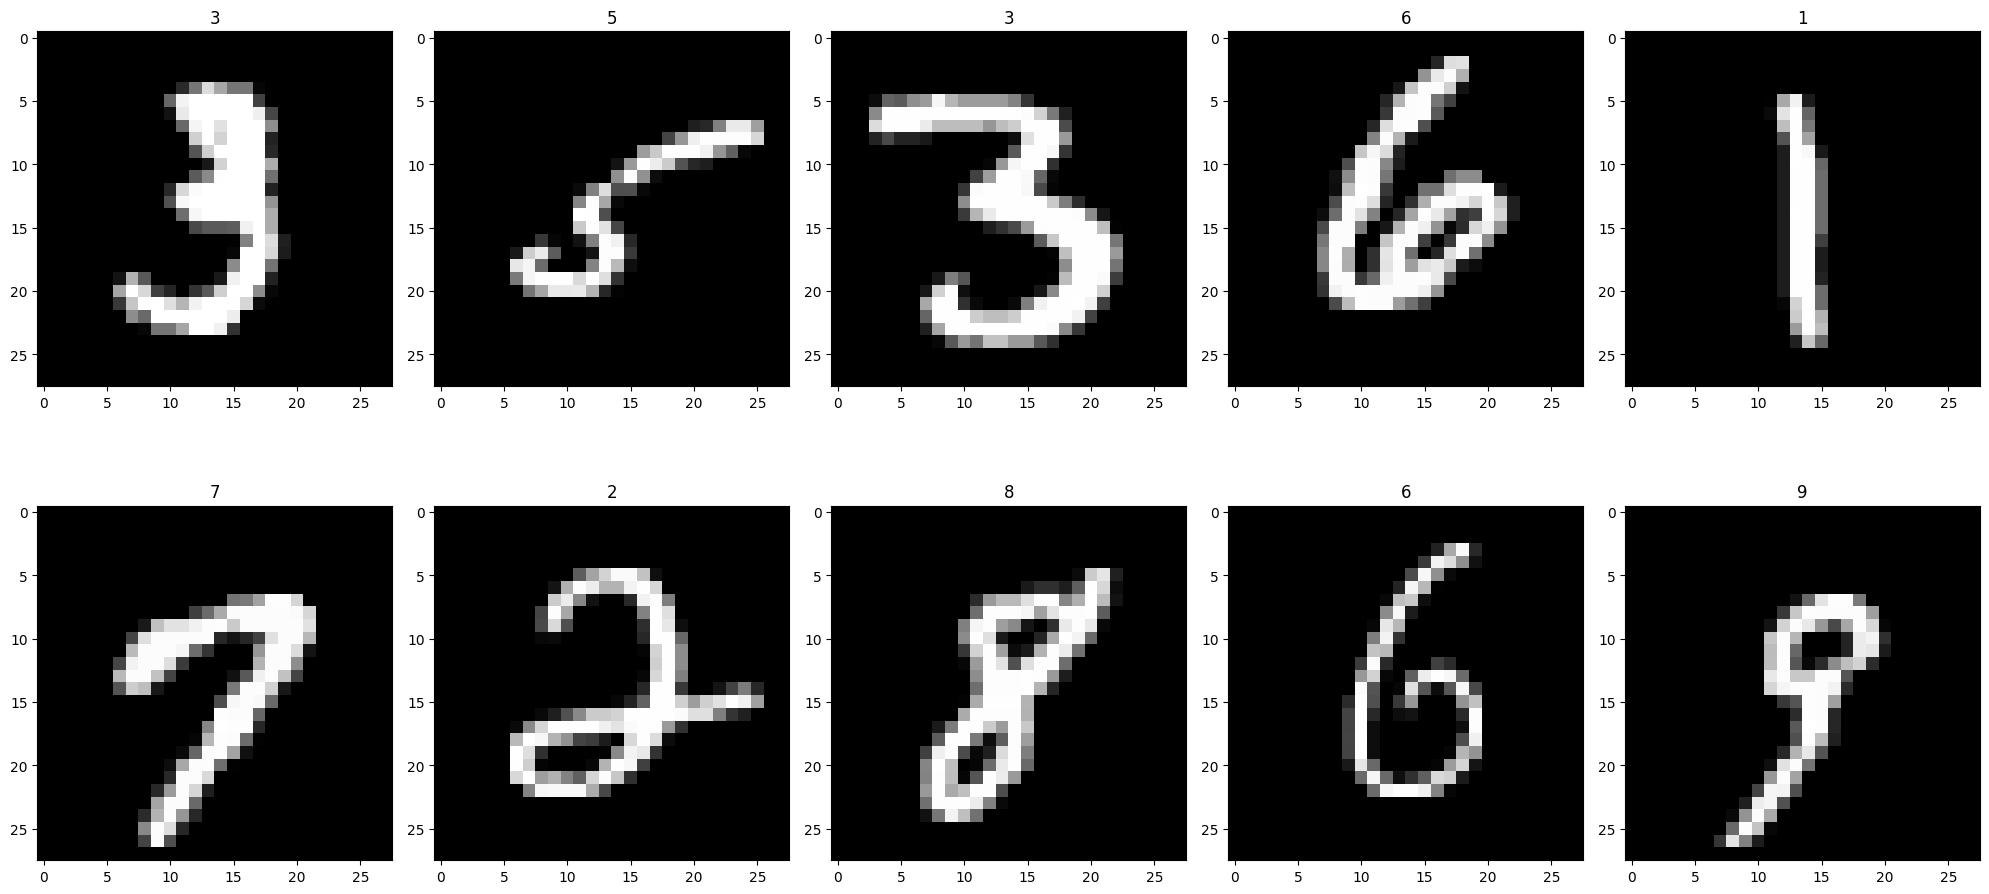

In [14]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]),cmap='gray')
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

In [15]:
#carica in un dataloader

batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

3. Creare una CNN compatibile con il dataset, eseguire i calcoli di parametri e output shape.



In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Parametri = 5*5*1 = 25 + 1 = 26 * 6 = 156
        self.pool = nn.MaxPool2d(2)      # Parametri = 0
        self.conv2 = nn.Conv2d(6, 16, 5) # Parametri = 5*5*6 = 25*6 = 150 + 1 = 151*16 = 2416


        self.fc1 = nn.Linear(256, 120) # Parametri = 256+ 1 = 257*120 = 30 840
        self.fc2 = nn.Linear(120, 84)         # Parametri = 120+1 = 121*84 = 10 164
        self.fc3 = nn.Linear(84, 10)          # Parametri = 84 + 1 = 85 * 10 = 850

    def forward(self, x):   #Input shape = N, 1, 28, 28
        x = self.conv1(x)   #Output shape = [N,6,24,24]
        x = F.relu(x)
        x = self.pool(x)    #Output shape = [N,6,12,12]

        x = self.conv2(x)   #Output shape = [N,16,8,8]
        x = F.relu(x)
        x = self.pool(x)    #Output shape = [N,16,4,4]

        x = torch.flatten(x, 1) # flatten su tutte le dimensioni [N, 16*4*4]

        x = self.fc1(x) # [N, 120]
        x = F.relu(x)
        x = self.fc2(x)  # [N, 84]
        x = F.relu(x)
        x = self.fc3(x)  # [N, 10]

        return x

In [20]:
net = Net().to(device)

In [21]:
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


4. Allenare la CNN.


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [23]:
net.train()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
for epoch in range(10):  # ripeti il training per 10 epoche

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # dal Dataloader estrai un batch
        inputs, labels = list(map(lambda x: x.to(device), data)) #[32,1, 28, 28], [32, 10]

        # resetta i gradienti dell'optimizer
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)   #[32, 10]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # Scrivi il log ogni 500 batch
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Fine del Training')

[Epoch 1, Batch   500] loss: 0.437
[Epoch 1, Batch  1000] loss: 0.119
[Epoch 1, Batch  1500] loss: 0.095
[Epoch 2, Batch   500] loss: 0.066
[Epoch 2, Batch  1000] loss: 0.061
[Epoch 2, Batch  1500] loss: 0.058
[Epoch 3, Batch   500] loss: 0.043
[Epoch 3, Batch  1000] loss: 0.044
[Epoch 3, Batch  1500] loss: 0.045
[Epoch 4, Batch   500] loss: 0.035
[Epoch 4, Batch  1000] loss: 0.036
[Epoch 4, Batch  1500] loss: 0.041
[Epoch 5, Batch   500] loss: 0.029
[Epoch 5, Batch  1000] loss: 0.028
[Epoch 5, Batch  1500] loss: 0.034
[Epoch 6, Batch   500] loss: 0.023
[Epoch 6, Batch  1000] loss: 0.029
[Epoch 6, Batch  1500] loss: 0.026
[Epoch 7, Batch   500] loss: 0.019
[Epoch 7, Batch  1000] loss: 0.019
[Epoch 7, Batch  1500] loss: 0.021
[Epoch 8, Batch   500] loss: 0.016
[Epoch 8, Batch  1000] loss: 0.024
[Epoch 8, Batch  1500] loss: 0.017
[Epoch 9, Batch   500] loss: 0.014
[Epoch 9, Batch  1000] loss: 0.014
[Epoch 9, Batch  1500] loss: 0.016
[Epoch 10, Batch   500] loss: 0.012
[Epoch 10, Batch  1

5. Testare la CNN e calcolare l'accuracy.

In [26]:
# conta le prediction corrette
correct_pred = 0
total_pred = 0
net.eval()
# non serve calcolare il gradiente
with torch.no_grad():
    for data in testloader:
        images, labels = list(map(lambda x: x.to(device), data))
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collezioniamo le prediction
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1
            total_pred += 1


accuracy = 100 * correct_pred / total_pred
print(f'Accuracy : {accuracy:.1f} %')

Accuracy : 98.9 %
